# **Recommender Systems and Personalization Datasets**

## Introduzione

Lo scopo di questa analisi è andare a sviluppare un sistema di raccomandazione che, in base alle precedenti valutazioni di un utente, gli suggerisca dei risultati che possono essere interessanti per lui grazie all'analisi di altri utenti con caratteristiche simili.

## Dati

Pacchetti utilizzati per l'analisi.

In [2]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns
import pandas as pd
import numpy as np
import gzip

In [3]:
import warnings
warnings.filterwarnings('ignore')

### (1) Analisi del Dataset

Il dataset che andremo ad utilizzare (`ModCloth`) è una raccolta di recensioni di utenti relative all'acquisto di capi di abbigliamento femminile dal sito web [modcloth.com](https://modcloth.com/). 

In [4]:
# Funzioni per importare file con estensione '.gz'.
def parse(path):
    g = gzip.open(path, 'rb')
    for l in g:
        yield eval(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')


# I dataset contengono recensioni di capi di abbigliamento acquistati su ModCloth.
ModCloth = getDF('data/modcloth_final_data.json.gz')

In [5]:
ModCloth.head()

,item_id,waist,size,quality,cup size,hips,bra size,category,bust,height,user_name,length,fit,user_id,shoe size,shoe width,review_summary,review_text
0,123373,29,7,5.0,d,38,34,new,36,5ft 6in,Emily,just right,small,991571,NaN,NaN,NaN,NaN
1,123373,31,13,3.0,b,30,36,new,NaN,5ft 2in,sydneybraden2001,just right,small,587883,NaN,NaN,NaN,NaN
2,123373,30,7,2.0,b,NaN,32,new,NaN,5ft 7in,Ugggh,slightly long,small,395665,9.00,NaN,NaN,NaN
3,123373,NaN,21,5.0,dd/e,NaN,NaN,new,NaN,NaN,alexmeyer626,just right,fit,875643,NaN,NaN,NaN,NaN
4,123373,NaN,18,5.0,b,NaN,36,new,NaN,5ft 2in,dberrones1,slightly long,small,944840,NaN,NaN,NaN,NaN


In [6]:
print(f'Dimensioni del dataset: {ModCloth.shape}')
print(f'Numero di recensioni: {ModCloth.shape[0]}')
print(f'Numero di utenti: {len(ModCloth.user_id.unique())}')
print(f'Numero di prodotti: {len(ModCloth.item_id.unique())}')

Dimensioni del dataset: (82790, 18)
Numero di recensioni: 82790
Numero di utenti: 47958
Numero di prodotti: 1378


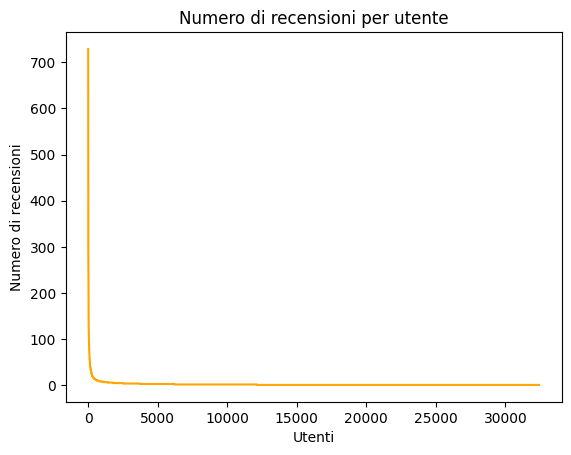

In [10]:
n_review = ModCloth.groupby('user_name').count().item_id

plt.plot(sorted(n_review.to_list(), reverse=True), color = 'orange')
plt.title('Numero di recensioni per utente')
plt.xlabel('Utenti')
plt.ylabel('Numero di recensioni');

Il dataset è formato da 18 variabili che reppresentano principalmente misure e taglie degli utenti che hanno fatto le 82 mila recensioni insieme alle valutazioni dei prodotti. I singoli utenti sono circa 48 mila e le recensioni fanno riferimento a 1378 prodotti differenti.

Variabili:
- **item_id**: unique product id
- **waist**: waist measurement of customer
- **size**: the standardized size of the product
- **quality**: rating for the product
- **cup size**: cup size measurement of customer
- **hips**: hip measurement of customer
- **bra size**: bra size of customer
- **category**: the category of the product
- **bust**: bust measurement of customer
- **height**: height of the customer
- **length**: feedback on the length of the product
- **fit**: fit feedback
- **user_name**: a unique id for the customer
- **shoe size**: shoe size of the customer
- **shoe width**: shoe width of the customer
- **review_text**: review of customer
- **review_summary**: review summary

In [7]:
# Rinominiamo le colonne per eliminare gli spazi tra le parole dei nomi delle variabili.
ModCloth.columns = ['item_id', 'waist', 'size', 'quality', 'cup_size', 'hips', 'bra_size',
                    'category', 'bust', 'height', 'user_name', 'length', 'fit', 'user_id',
                    'shoe_size', 'shoe_width', 'review_summary', 'review_text']

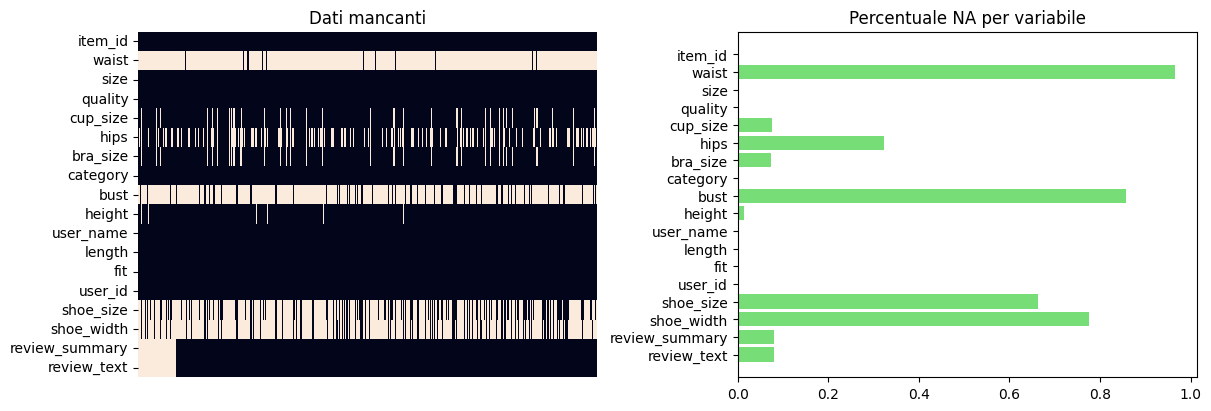

Percentuale di dati mancanti per ogni variabile:


,review_text,review_summary,shoe_width,shoe_size,user_id,fit,length,user_name,height,bust,category,bra_size,hips,cup_size,quality,size,waist,item_id
0,0.08123,0.08123,0.775251,0.662822,0.0,0.0,0.000423,0.0,0.013371,0.856818,0.0,0.07269,0.322817,0.075553,0.000821,0.0,0.965189,0.0


Struttura delle variabili:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 82790 entries, 0 to 82789
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   item_id         82790 non-null  object 
 1   waist           2882 non-null   object 
 2   size            82790 non-null  int64  
 3   quality         82722 non-null  float64
 4   cup_size        76535 non-null  object 
 5   hips            56064 non-null  object 
 6   bra_size        76772 non-null  object 
 7   category        82790 non-null  object 
 8   bust            11854 non-null  object 
 9   height          81683 non-null  object 
 10  user_name       82790 non-null  object 
 11  length          82755 non-null  object 
 12  fit             82790 non-null  object 
 13  user_id         82790 non-null  object 
 14  shoe_size       27915 non-null  object 
 15  shoe_width      18607 non-null  object 
 16  review_summary  76065 non-null  object 
 17  revi

In [8]:
# Visualizzazione valori mancanti.
fig, (ax1, ax2)= plt.subplots(1,2, constrained_layout=True)
fig.set_size_inches(12, 4)

# Grafico posizione dati mancati.
sns.heatmap(ax = ax1, data=ModCloth.isna().transpose(), cbar=False)
ax1.set(title='Dati mancanti', xlabel=None)
ax1.set_xticks([])

# Grafico percentuale dati mancanti.
perc_NA = pd.DataFrame(ModCloth.isna().sum() / ModCloth.shape[0])[::-1]
ax2.barh(np.arange(len(perc_NA.index)), perc_NA[0].to_list(), color = '#77DD77')
ax2.set(title='Percentuale NA per variabile')
ax2.set_yticks(np. arange(len(perc_NA)), perc_NA.index)
plt.show()


print('Percentuale di dati mancanti per ogni variabile:')
display(perc_NA.T)

print('Struttura delle variabili:')
ModCloth.info()

All'interno del dataset sono presenti molti valori mancanti, soprattutto in alcune variabili come "waist" e "bust". Solo 6 delle 18 hanno tutti i valori presenti: probabilmente sono valori inseriti di default all'interno della recensione del prodotto.

In [9]:
# Eliminiamo le righe del dataframe che si ripetono.
ModCloth.duplicated().sum()  # ---> 377
ModCloth = ModCloth.drop_duplicates()

Consideriano anche alcuni dati relativi agli utenti e ai capi acquistati.

In [10]:
mean_user = round(ModCloth.groupby('user_id').item_id.count().mean(), 2)
max_user = ModCloth.groupby('user_id').item_id.count().max()
print(f'Numero medio di acquisti per utente: {mean_user}')
print(f'Numero massimo di acquisti fatti da un utente: {max_user}\n')

mean_item = round(ModCloth.groupby('item_id').count().mean()[0], 2)
max_item = ModCloth.groupby('item_id').count().max()[0]
print(f'Numero medio di acquisti di un capo: {mean_item}')
print(f'Numero massimo di acquisti di un capo: {max_item}')

Numero medio di acquisti per utente: 1.72
Numero massimo di acquisti fatti da un utente: 27

Numero medio di acquisti di un capo: 2.09
Numero massimo di acquisti di un capo: 38


### (1) Analisi delle Variabili

Data la loro alta concentrazioni di valori mancanti (maggiore dell'80%) decidiamo di eliminare le variabili "waist" e "bust". Per le variabili "length", "height" e "quality" che invece presentano solo pochi valori mancanti, semplicemente cancelliamo le righe.

In [11]:
# Eliminiamo le colonne superflue.
ModCloth.drop(['waist', 'bust'], axis=1, inplace=True)

# Eliminiamo poche righe con valori mancanti per "length", "height" e "quality".
ModCloth.dropna(subset=['length', 'height', 'quality'], inplace=True)

Osserviamo il comportamento delle variabili categoriche presenti.

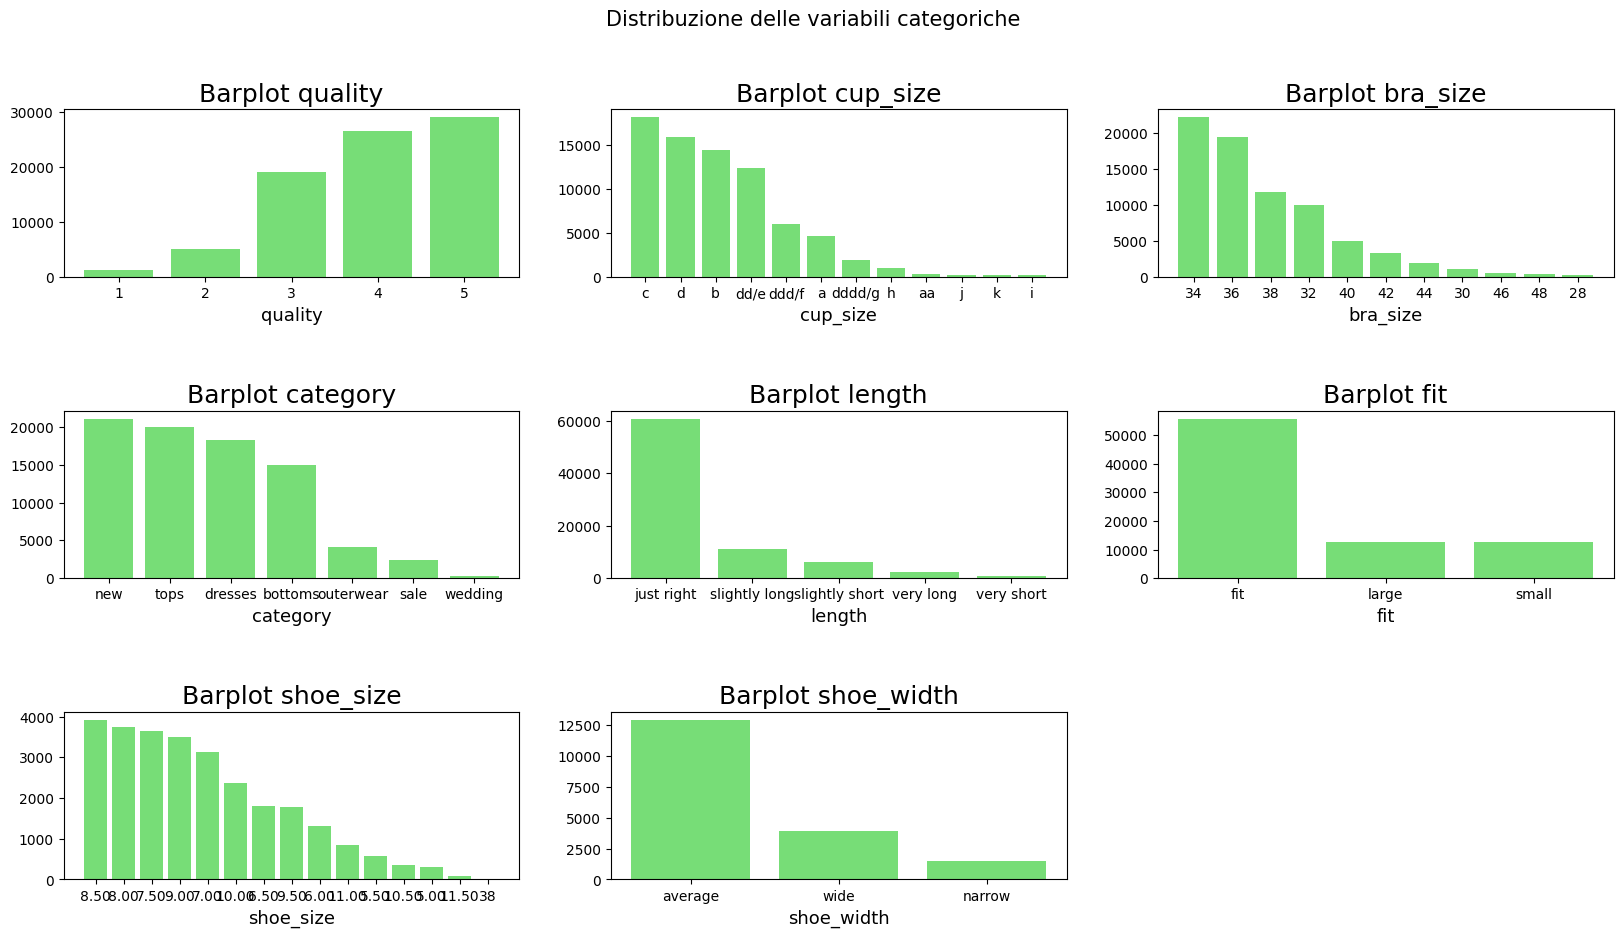

In [12]:
# Funzione che restituisce etichette e altezze del barplot per una variabile categorica.
def barplot_attr(col):
    labels = col.value_counts().index
    h = col.value_counts().values
    return labels, h

# Variabili categoriche.
cat_var = ['quality', 'cup_size', 'bra_size', 'category', 'length', 'fit', 'shoe_size', 'shoe_width']


fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=.8)
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

for i in range(1, len(cat_var)+1):
    ax = fig.add_subplot(3, 3, i)
    labels, h = barplot_attr(ModCloth[cat_var[i-1]])
    ax.bar(labels, h, color='#77DD77')
    ax.set_xlabel(cat_var[i-1], fontsize=13)
    ax.set_title(f'Barplot {cat_var[i-1]}', fontsize= 18)

plt.suptitle("Distribuzione delle variabili categoriche", fontsize= 15)
plt.show()

Per la variabile "quality" notiamo come la maggior parte delle recensioni sia valutate positivamente (supponendo 5 positive e 1 negative). le variabili "cup_size" e "bra_size" hanno un andamento simile all'interno delle categorie (variabili entrambe riferite a misure del seno). Per quanto riguarda la categorizzazione dei capi notiamo come quelli più recensiti, e presumibilmente più acquistati, sono quelli che si trovano nella categoria novità e tops (maglie o camicie), piuttosto che non quelli nella categoria sconti come invece si sarebbe potuto pensare. Per quanto riuguarda le misure dei capi la maggir parte degli utenti le ha trovate corrette. Anche per la variabile "shoe_size" troviamo un andamento simile ad alcuni riscontrati prima: questa caratteristica è presente in quelle variabili che presentano molte categorie delle quali alcune sono molto più comuni mentre altre sono rivolte a pochi. Anche la calzabilità delle scarpe, come per quella degli altri capi di abbigliamento, risulta buona per la maggior parte degli utenti ("shoe_width").

Andiamo ora ad osservare come si comportano queste varibili se andiamo ad inserire al posto dei dati mancanti il valore "Unknown".

In [13]:
for var in cat_var:
    ModCloth[var] = ModCloth[var].fillna('Unknown')

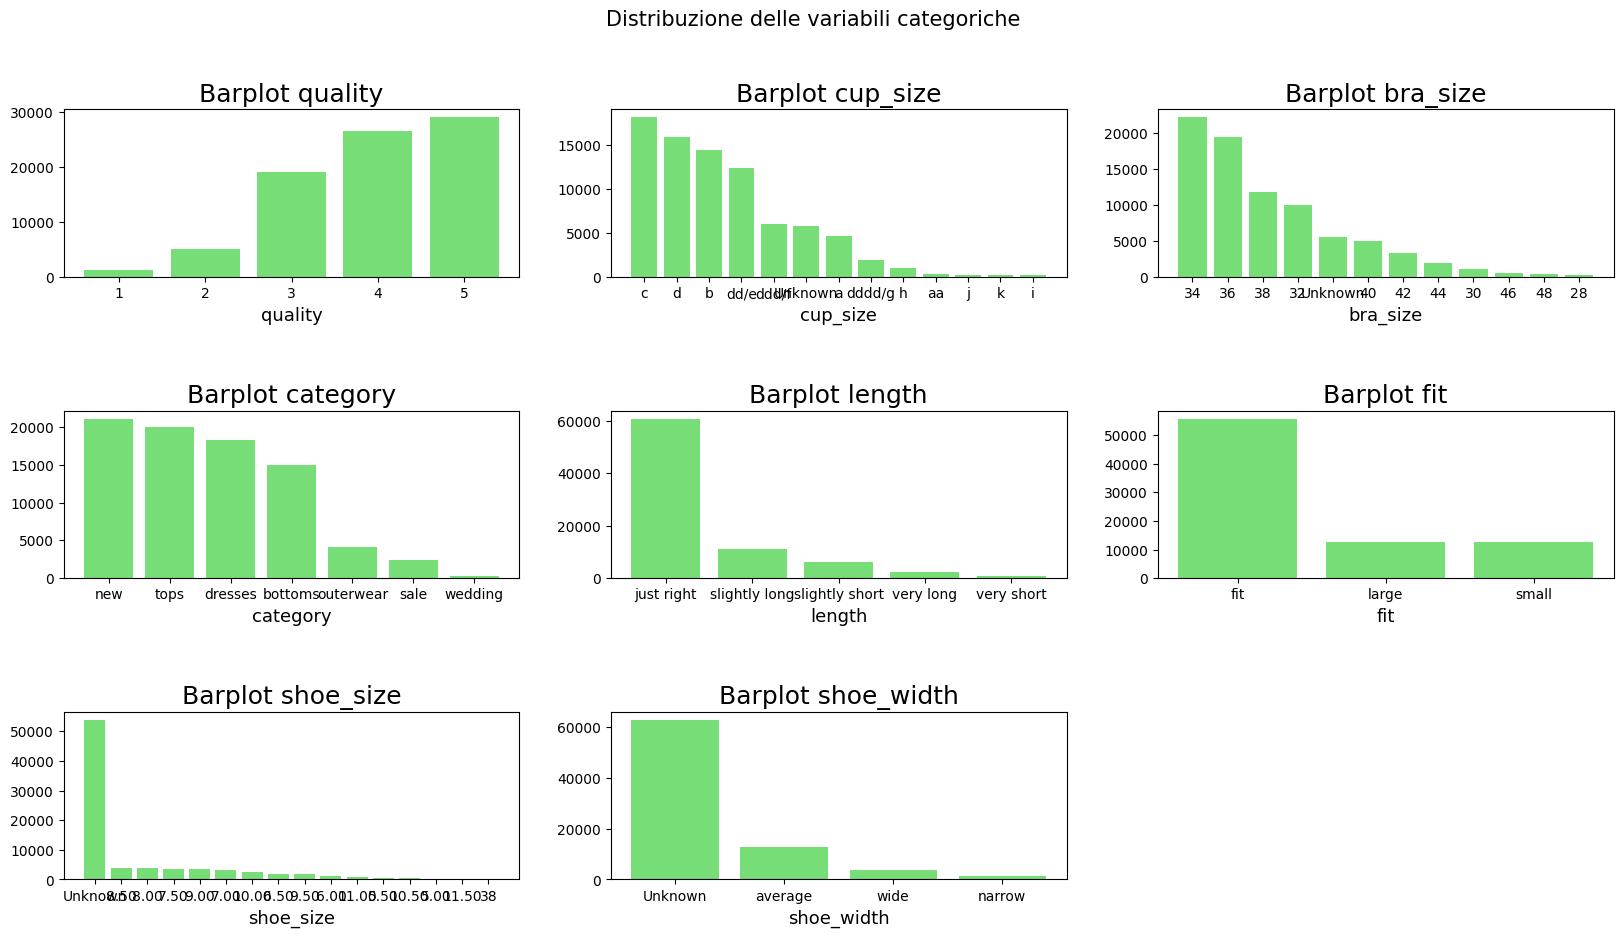

In [14]:
fig = plt.figure(figsize = (20,10))
fig.subplots_adjust(hspace=.8)
fig.tight_layout(h_pad=9, w_pad=2, rect=[0, 0.03, 1, 0.93])

for i in range(1, len(cat_var)+1):
    ax = fig.add_subplot(3, 3, i)
    labels, h = barplot_attr(ModCloth[cat_var[i-1]])
    ax.bar(labels, h, color='#77DD77')
    ax.set_xlabel(cat_var[i-1], fontsize=13)
    ax.set_title(f'Barplot {cat_var[i-1]}', fontsize= 18)

plt.suptitle("Distribuzione delle variabili categoriche", fontsize= 15)
plt.show()

Mentre per le variabili *cup_size* e *bra_size* la categoria 'Unknown' ha delle frequenze di dati basse, per le variabili relative alle scarpe ha un impatto rilevante, come ci aspettavamo data l'alta presenza di valori mancanti.
Decidiamo quindi non andare a considerare nemmeno queste due variabili per la successiva analisi.

Vediamo ora le variabili continue come si comportano.

In [15]:
# "height" è in piedi e la riformattiamo in cm.
def ft_to_cm(x):
    if len(x)>3: 
        return (int(x[0])*30.48) + (int(x[4:-2])*2.54)
    else:
        return (int(x[0])*30.48)

ModCloth.height = ModCloth.height.apply(ft_to_cm)

# Assegnamo ai valori mancanti di "hips" il valore -1.
ModCloth.hips = ModCloth.hips.fillna(-1.0)
ModCloth.hips = ModCloth.hips.astype('float')

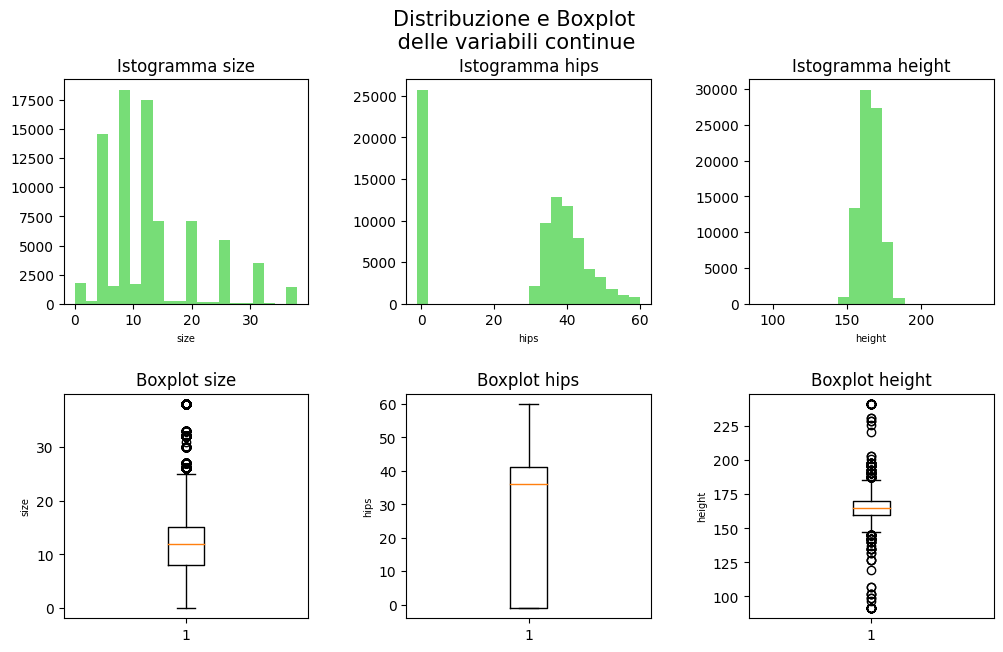

In [16]:
cont_var = ['size', 'hips', 'height']

fig = plt.figure(figsize = (12,7))
plt.subplots_adjust(wspace=0.4, hspace=0.4)
fig.tight_layout(rect=[0, 0.03, 1, 0.93])

# Istogrammi.
for i in range(1, len(cont_var)+1):
    ax = fig.add_subplot(2, 3, i)
    ax.hist(ModCloth[cont_var[i-1]], color='#77DD77', bins = 20)
    ax.set_xlabel(cont_var[i-1], fontsize=7)
    ax.set_title(f'Istogramma {cont_var[i-1]}', fontsize= 12)

# Boxplot.
for i in range(1, len(cont_var)+1):
    ax = fig.add_subplot(2, 3, i+3)
    ax.boxplot(ModCloth[cont_var[i-1]])
    ax.set_ylabel(cont_var[i-1], fontsize=7)
    ax.set_title(f'Boxplot {cont_var[i-1]}', fontsize= 12)

plt.suptitle("Distribuzione e Boxplot\n delle variabili continue", fontsize= 15)
plt.show()

Per la variabile "size" notiamo subito come, nonostante sia una variabile continua, molte taglie o non sono presenti o sono acquistato con poca frequenza. La distribuzione delle misure della variabile "hips" assume una forma più continua presentando alcuni outliers per valori alti; tutti i valori mancanti sono stati riformattati con il valore -1 e se dovessimo sostituirli con il valore medio sarebbero troppi, andando così a distorcere la forma dell'attuale distribuzione: anche in questo caso decidiamo di scratare la variabile successivamente. La variabile che rappresenta l'altezza invece ("height") ha una distibuzione molto addensata intorno al valore media poichè, come vediamo dal boxplot, presenta svariati outliers sia per valori bassi che per valori alti.

In [17]:
min(ModCloth.height)

91.44

I valori bassi della variabile *height* possiamo considerarli come validi considerando che potrebbero essere stati acquisti per delle bambine, dato che il valore più basso che la variabile assume è 91 cm. Per i valori alti dobbiamo fare un'altra cosiderazione.

In [18]:
ModCloth[ModCloth.height > 220].groupby('user_name').height.max()

user_name
Ida             241.30
Laurence        228.60
Samma           220.98
a.roodman       231.14
angelapye       228.60
bandnerd2522    241.30
colmaggie       241.30
lab262          226.06
Name: height, dtype: float64

In [19]:
ModCloth[ModCloth.height > 220].groupby('user_name').count()

,item_id,size,quality,cup_size,hips,bra_size,category,height,length,fit,user_id,shoe_size,shoe_width,review_summary,review_text
user_name,,,,,,,,,,,,,,,
Ida,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Laurence,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Samma,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
a.roodman,2,2,2,2,2,2,2,2,2,2,2,2,2,2,2
angelapye,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
bandnerd2522,20,20,20,20,20,20,20,20,20,20,20,20,20,20,20
colmaggie,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
lab262,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


In [20]:
ModCloth[ModCloth.user_name == 'bandnerd2522'].mode().loc[0]

item_id                                                      161514
size                                                           12.0
quality                                                         5.0
cup_size                                                          k
hips                                                           60.0
bra_size                                                         48
category                                                       tops
height                                                        241.3
user_name                                              bandnerd2522
length                                                   just right
fit                                                           small
user_id                                                      708288
shoe_size                                                     11.50
shoe_width                                                  average
review_summary                            I LOVE

Non ci sono molti utenti con un'altezza maggiore di 220; notiamo in paritcolare una donna che ha 20 recensioni differenti all'interno del dataset tutte con la stessa altezza. Decidiamo di eliminare questi utenti perchè rappresentano una percentuale minima della nostra popolazione.

In [21]:
ModCloth = ModCloth[ModCloth.height < 220]

Infine le variabili "review_summary" e "review_text", essendo testuali, non le andremo a considerare.

### Relazioni tra variabili

In [22]:
def comparative_barplot(data, title, vars):
    labels = data.index
    lab_range = np.arange(len(labels))
    columns = data.columns
    w = 1 / (len(columns)+1)
    for i in range(len(columns)):
        plt.bar(lab_range + w*i, data[columns[i]], width= w, label = columns[i])

    plt.xticks(lab_range + w*(len(columns)//2), labels)
    plt.xlabel(vars[0])
    plt.title(title)
    plt.legend(title=vars[1])

In [73]:
def comparative_boxplot(cat, cont):
    d = {}
    names = set(ModCloth[cat])
    for el in names:
        d[el] = ModCloth[cont][ModCloth[cat] == el].values

    plt.boxplot(d.values())
    plt.xlabel(cat)
    plt.ylabel(cont)
    plt.xticks(range(1, len(names)+1), names)
    plt.title(f'{cat} vs {cont}');

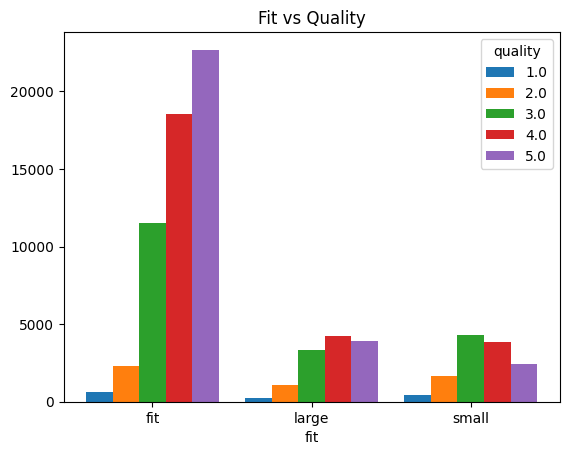

In [23]:
data = ModCloth.groupby('fit').quality.value_counts().unstack()
comparative_barplot(data, 'Fit vs Quality', ['fit', 'quality'])

Gli utenti hanno recensito lievemente peggio gli indumenti che non calzano benissimo: mentre nella categoria fit della variabile "fit" la maggior parte degli utenti ha valutato i prodotti con recensioni per lo più positive, per le altre due categorie le recensioni tendono ad abbassarsi (le categorie 3 e 4 sono superiori rispetto a 5).

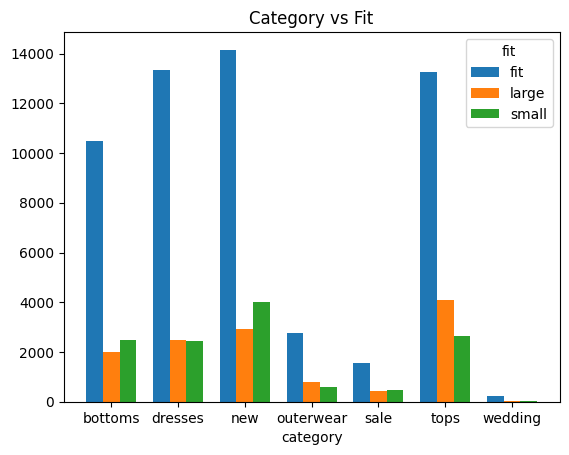

In [24]:
data = ModCloth.groupby('category').fit.value_counts().unstack()
comparative_barplot(data, 'Category vs Fit', ['category', 'fit'])

Per quanto riguarda le categorie in cui gli indumenti sono stati classificati, notiamo come in tutte le categorie si ripete lo stesso andamento: la maggior parte dei capi calzano bene mentre una quantità inferiore ha un fit più grande o più piccolo.

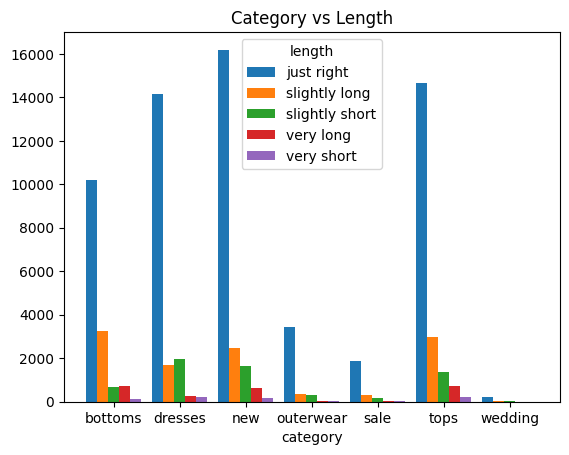

In [25]:
data = ModCloth.groupby('category').length.value_counts().unstack()
comparative_barplot(data, 'Category vs Length', ['category', 'length'])

Anche per quanto riguarda la lunghezza dei capi, questo barplot rispetta le caratteristiche emerse nel grafico precedente.

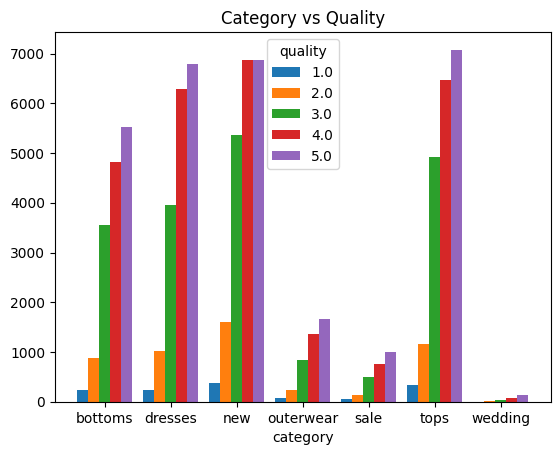

In [82]:
data = ModCloth.groupby('category').quality.value_counts().unstack()
comparative_barplot(data, 'Category vs Quality', ['category', 'quality'])

Qui vediamo come le recensioni hanno una struttura omogenea all'interno di tutte le categorie di indumenti.

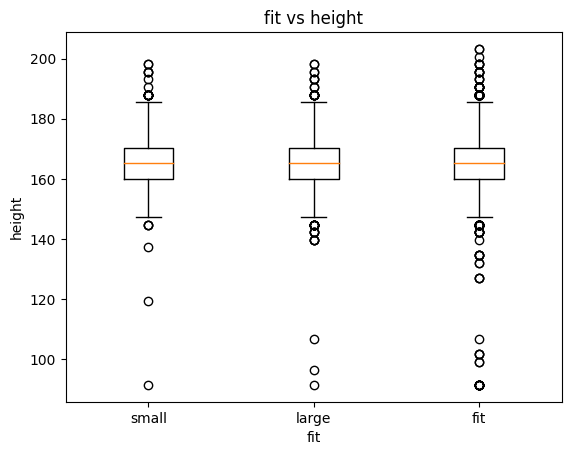

In [76]:
comparative_boxplot('fit', 'height')

Possiamo notare come il fit sia indipendente dalla variabile 'height' e successivamente come lo sia anche la variabile 'quality' per la variabile continua taglia.

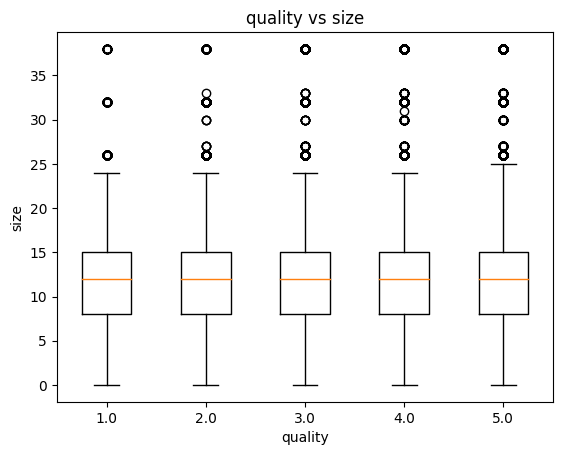

In [84]:
comparative_boxplot('quality', 'size')

## Recommendation System

### Dati per il modello

Dal dataset iniziale `ModCloth` andiamo ad estrarre le variabili 'user_name', 'item_id' e 'quality'. Con queste tre variabili andremo ad allenare un modello per il nostro Recommandetion System che ci darà la possibilità di consigliare ad un utente degli item che potrebbero interessargli, in base agli acquisti che ha fatto in precedenza ed ha recensito.

In [2]:
from surprise import Reader, Dataset, KNNBasic

In [3]:
# Consideriamo come user ID la variabile user_name poichè presenta meno valori unici nel dataset.
len(ModCloth.user_id.unique()) # --> 47176
len(ModCloth.user_name.unique()) # --> 31883

df = ModCloth[['user_name', 'item_id', 'quality']]
df.columns = ['user_id', 'item_id', 'rating']

L'intero dataset pulito è formato da circa 80 mila righe: all'interno sono recensiti 1364 item da 31883 utenti differenti. Per motivi computazionali andremo a considerare solo gli utenti che hanno un numero di recensioni superiore ad una certa soglia per i seguenti motivi:
- dovendo riempire la matrice di rating con i valori predetti del modello avremmo bisogno di troppo spazio in memoria quindi abbiamo bisogno di un campione più piccolo;
- anche se non in maniera del tutto corretta, possiamo andare a restituire delle raccomandazioni per l'acquisto di altri prodotti considerando solo gli utenti che hanno fatto molte recensioni; questo ci permette di avere delle raccomandazione specifiche per l'utente: andando infatti a considerare utenti con pochissime recensioni sorge il problema di mancanza di utenti simili poichè si hanno pochi valori per fare il confronto e il nostro modello andrebbe a suggerire dei prodotti in maniera quasi randomica.

Fatte queste considerazioni andiamo a considerare solo gli utenti con più di 100 recensioni.

In [4]:
# Estrazione utenti con più di 100 recensioni.
best_users = df.groupby('user_id').count().item_id[df.groupby('user_id').count().item_id > 100].index
df_sample = df[df.user_id.isin(best_users)]

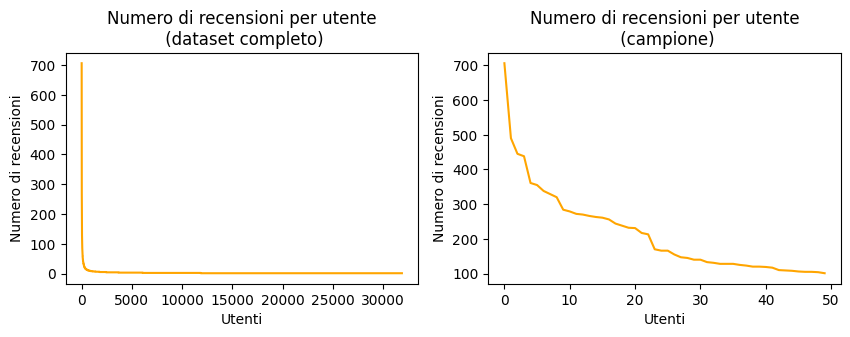

In [5]:
# Plot del numero di recensioni per utente.
fig = plt.figure(figsize = (10,3))

n_review = df.groupby('user_id').count().item_id
ax = fig.add_subplot(1,2,1)
ax.plot(sorted(n_review.to_list(), reverse=True), color = 'orange')
ax.set_title('Numero di recensioni per utente\n (dataset completo)')
ax.set_xlabel('Utenti')
ax.set_ylabel('Numero di recensioni')

n_review = df_sample.groupby('user_id').count().item_id
ax = fig.add_subplot(1,2,2)
ax.plot(sorted(n_review.to_list(), reverse=True), color = 'orange')
ax.set_title('Numero di recensioni per utente\n (campione)')
ax.set_xlabel('Utenti')
ax.set_ylabel('Numero di recensioni')

plt.show()

Vediamo come l'andamento, anche se consideriamo solo utenti con molte recensioni, tende ad essere simile per l'intero dataset e per il campione considerato.

In [6]:
# Modelliamo il dataset per renderlo utilizzabile per allenare il nostro modello (K-NN).
reader = Reader(rating_scale=(df_sample.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df_sample, reader)

### (2) Ricerca dei migliori valori degli iperparametri

In [7]:
from surprise.model_selection import cross_validate

Ricerchiamo i valori degli iperparametri che meglio ottimizzano il modello in base ai nostri dati, valutando le varie conbinazioni sulla base del RMSE (Root Mean Square Error).
Gli iperparametri che consideriamo sono:
- **k**: numero di vicini da considerare
- **name**: metrica per misurare la distanza tra gli utenti
- **user_based**: user_based o item_based

Per fare questa analisi utilizziamo costruiamo una grid search: dati diversi valori degli iperparametri considerati proviamo tutte le combinazioni possibili ottimizzandole tramite cross validation per cui settiamo un valore pari a 3.

In [26]:
# Settiamo i valori degli iperparametri che vogliamo testare.
similarity = ['msd', 'cosine', 'pearson', 'pearson_baseline']
k_grid = np.arange(1,30) 
user_based = [False, True]

res = {}

for based in user_based:
    res = {}
    for pos,s in tqdm(enumerate(similarity)):
        RMSE = []
        MSE = []
        for k in k_grid:
            sim_options = {
                "k": k,
                "name": s,
                "user_based": based, 
            }

            # Per ogni combinazione valutiamo il modello.
            model = KNNBasic(sim_options = sim_options)
            results = cross_validate(model, data, measures=['RMSE', 'MSE'], cv=3, verbose=0, n_jobs=-1)
            RMSE.append(np.mean(results['test_rmse']))
            MSE.append(np.mean(results['test_mse']))
            
        res[s] = (k_grid[np.argmin(RMSE)], min(MSE), min(RMSE))

    results = pd.DataFrame(res, index=['k', 'MSE', 'RMSE'])
    display(results.style.set_caption(f"user_based = {based}"))
    
    # Salviamo i valori che ottimizzano meglio il modello.
    new_k = int(results.loc['k'][np.argmin(results.loc['RMSE'])])
    new_metric = results.columns[np.argmin(results.loc['RMSE'])]
    new_based = based
    new_best_rmse = results[new_metric].loc['RMSE']
    new_best_mse = results[new_metric].loc['MSE']
    if based:
        if new_best_rmse < best_rmse_knn:
            best_k = new_k
            best_metric = new_metric
            best_based = new_based
            best_rmse_knn = new_best_rmse
            best_mse_knn = new_best_mse
    else:
        best_k = new_k
        best_metric = new_metric
        best_based = new_based
        best_rmse_knn = new_best_rmse
        best_mse_knn = new_best_mse

print(f"Scegliamo i seguenti valori per gli iperparametri:\n- k: {best_k}\n- name: {best_metric}\n- user_based: {best_based}\n")
print(f"RMSE: {best_rmse_knn}, MSE: {best_mse_knn}")

4it [01:09, 17.39s/it]


,msd,cosine,pearson,pearson_baseline
k,10.000000,13.000000,6.000000,25.000000
MSE,0.952197,0.961735,1.013475,1.023227
RMSE,0.975799,0.980643,1.006695,1.011498


4it [00:31,  7.86s/it]


,msd,cosine,pearson,pearson_baseline
k,13.000000,25.000000,11.000000,29.000000
MSE,0.916871,0.913571,0.971583,1.096974
RMSE,0.957523,0.955756,0.985666,1.047351


Scegliamo i seguenti valori per gli iperparametri:
- k: 25
- name: cosine
- user_based: True

RMSE: 0.9557556542480854, MSE: 0.9135712965717703


### (3) Train del modello e filling della matrice di rating

Utilizziamo ora i valori ottimali trovati per allenare il nostro modello e fare successivamente delle previsioni, andando così a riempire la *matrice di rating*.

In [27]:
# Estraiamo gli ID di tutti gli utenti e di tutti i prodotti.
unique_users = df_sample.user_id.unique()
unique_users.sort()
unique_items = df_sample.item_id.unique()
unique_items.sort()

# Alleniamo il modello con i valori ottimali trovati in precedenza.
trainset = data.build_full_trainset()
sim_options = {
    "k": best_k,
    "name": best_metric,
    "user_based": best_based, 
}
model = KNNBasic(sim_options = sim_options) 
model.fit(trainset)

# Chiediamo al modello di prevedere la valutazione di ogni utente ad ogni item.
test_set = [[user, item, 3] for user in tqdm(unique_users) for item in unique_items]
pred = [model.predict(i[0], i[1]).est for i in tqdm(test_set)]

# Riempiamo la matrice di rating con i valori predetti.
rating_matrix = np.reshape(pred, (len(unique_users), len(unique_items)))
rating_dataframe = pd.DataFrame(rating_matrix, columns=unique_items, index=unique_users)
print("Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item")
rating_dataframe.head(20)

Computing the cosine similarity matrix...
Done computing similarity matrix.


100%|██████████| 32550/32550 [00:00<00:00, 54665.60it/s]

Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item


,123373,124124,124761,125442,125602,126560,126885,129268,130225,130424,...,803464,803768,804295,805172,805642,806479,806856,807252,807384,807722
Allison,4.833214,3.928434,4.666822,4.150556,5.0,3.801804,3.874394,3.898149,3.626473,3.665898,...,3.826461,3.531407,5.0,4.751633,3.242259,4.171680,4.449598,4.0,3.997961,3.750234
Alyssa,4.833627,3.929366,4.665354,4.048922,5.0,3.806246,3.950390,3.897275,3.622284,3.667318,...,3.825984,3.531743,5.0,4.749172,3.245215,4.348761,4.649150,4.0,4.000994,3.751589
Amanda,4.833073,3.929878,4.671782,3.921495,5.0,3.799843,3.951167,3.898147,3.622059,3.664279,...,3.826621,3.533128,5.0,4.749832,3.249101,4.527495,4.423499,4.0,3.999095,3.749862
Amber,4.832000,3.927804,4.665472,4.076679,5.0,3.801867,3.853304,3.901700,3.622633,3.661890,...,3.826802,3.533433,5.0,4.749113,3.246212,4.324278,4.446790,4.0,4.001114,3.739405
Amy,4.832748,3.932105,4.665092,4.075877,5.0,3.797359,3.950712,3.897897,3.625490,3.665092,...,3.824935,3.532455,5.0,4.750506,3.251126,4.374909,4.599752,4.0,3.999457,3.751520
Andrea,4.833448,3.930874,4.665168,4.150381,5.0,3.802877,4.000950,3.896885,3.625734,3.662424,...,3.826561,3.534282,5.0,4.749816,3.246709,4.425876,4.625078,4.0,4.000157,3.756689
Angela,4.834276,3.930649,4.665484,4.199639,5.0,3.800418,3.926776,3.898407,3.624538,3.662548,...,3.826409,3.531229,5.0,4.745273,3.250431,4.374996,4.474970,4.0,3.996977,3.749523
Anna,4.833004,3.930343,4.664617,4.049901,5.0,3.801317,4.026217,3.897372,3.629764,3.664292,...,3.825812,3.528432,5.0,4.750223,3.245399,4.323950,4.451152,4.0,3.997945,3.751968
Ashley,4.832212,3.928731,4.665552,4.153195,5.0,3.800106,3.849236,3.898193,3.625715,3.679211,...,3.826568,3.539681,5.0,4.750160,3.249682,4.499255,4.599777,4.0,4.000827,3.751986
Brittany,4.833364,3.929698,4.665741,3.998453,5.0,3.802018,3.925844,3.898039,3.625401,3.660533,...,3.826443,3.531547,5.0,4.747558,3.250187,4.400060,4.550703,4.0,3.999682,3.748399


Se non ci sono abbastanza vicini viene assegnato al valore della predizione la media globale di tutti i rating. Il valore minimo di vicini minimi è settato di default a 1.

In [28]:
# Media globale dei rating.
trainset.global_mean

3.9736915496885747

### (4) Segmentazione degli utenti in base alle preferenze

In [11]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

Calcoliamo la distanza tra gli utenti tramite la *Cosine Similarity* (df_cosine) e cerchiamo il numero ottimale di cluster in cui raggrupparli data questa matrice di similarità usando l'**Elbow Method**.

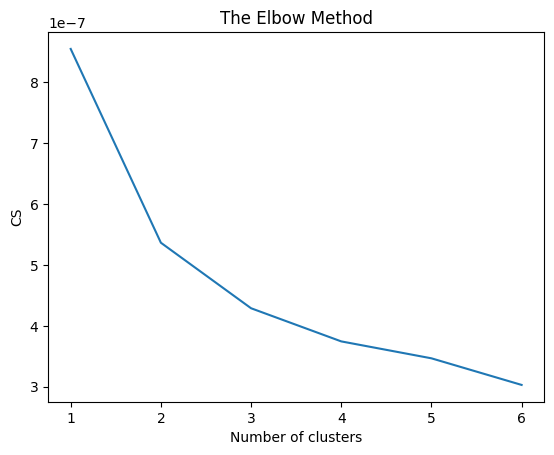

In [29]:
# Calcolo delle cosine similarity tra gli utenti.
df_cosine=pd.DataFrame(cosine_similarity(rating_dataframe, dense_output=True))

# Elbow Method.
cs = []
range_k = list(range(1,7))
for i in range_k:
    kmeans = KMeans(n_clusters = i, max_iter = 300, n_init = 10, random_state = 0)
    kmeans.fit(df_cosine)
    cs.append(kmeans.inertia_)
    
plt.plot(range_k, cs)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('CS')
plt.show()

Come valore di k andreamo a prendere il punto in cui la curva forma un gomito: usiamo perciò 2 cluster.

Andando a considerare le prime due componenti principali applichiamo poi l'algoritmo K-Means per raggruppare gli utenti simili tra loro rappresentandoli graficamente.

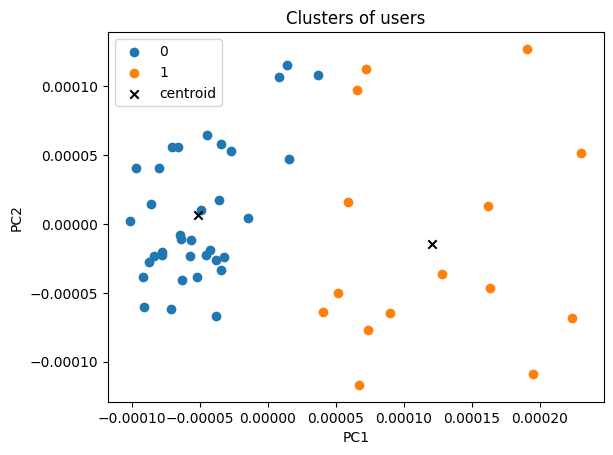

In [30]:
# Prime 2 componenti principali.
data = df_cosine
pca = PCA(2)
transform = pca.fit_transform(data)

# KMeans con valore di k precedentemente trovato.
k = 2
kmeans = KMeans(n_clusters = k)
label = kmeans.fit_predict(transform)
u_labels = np.unique(label)

# Plot dei cluster.
plt.figure()
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(kmeans.cluster_centers_[:,0],kmeans.cluster_centers_[:,1],color='black',marker='x',label='centroid')
plt.legend()
plt.title('Clusters of users')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

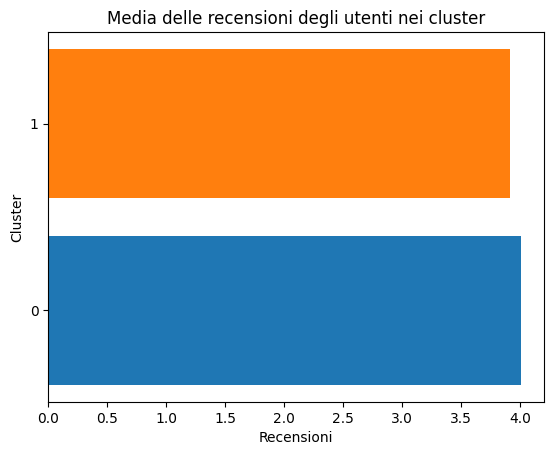

In [31]:
label_kmeans = pd.DataFrame({'user_id' : rating_dataframe.index, 'label': label})
avg_review_0 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 0].user_id)].groupby('user_id').mean().rating.mean()
avg_review_1 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 1].user_id)].groupby('user_id').mean().rating.mean()

cluster = [0, 1]
plt.barh(cluster, [avg_review_0, avg_review_1], color = ['tab:blue', 'tab:orange'])
plt.yticks(cluster)
plt.xlabel('Recensioni')
plt.ylabel('Cluster')
plt.title('Media delle recensioni degli utenti nei cluster');

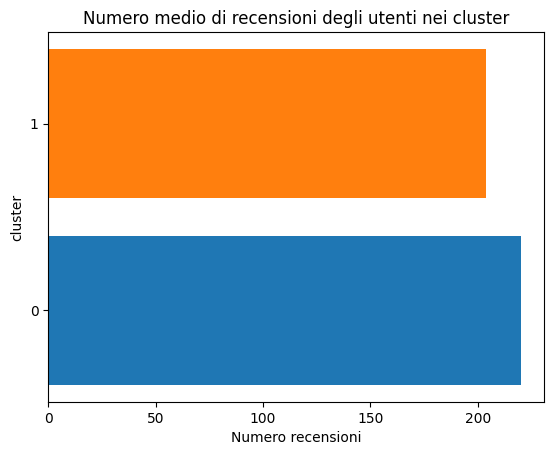

In [32]:
avg_review_0 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 0].user_id)].groupby('user_id').count().item_id.mean()
avg_review_1 = df_sample[df_sample.user_id.isin(label_kmeans[label_kmeans.label == 1].user_id)].groupby('user_id').count().item_id.mean()

plt.barh(cluster, [avg_review_0, avg_review_1], color = ['tab:blue', 'tab:orange'])
plt.yticks(cluster)
plt.ylabel('cluster')
plt.xlabel('Numero recensioni')
plt.title('Numero medio di recensioni degli utenti nei cluster');

Notiamo dai grafici sovrastanti come il valore medio delle recensioni cambia di poco tra i due gruppi mentre si ha una differenza leggermente maggiore per quanto riguarda la quantità media di recensioni per utente.

### (5) N item da consigliare ad ogni utente

Creiamo una funzione che restituisce una lista di n item ordinata per il valore del rating predetto: vengono riportati solo gli item che l'utente non ha recensito già. 

In [16]:
def top_n_recommendation(user_id, ratings_df, n_items, all_users = False):

    # Controllo se l'utente esiste nella nostra lista.
    users_id = ratings_df["user_id"].unique()
    if user_id not in users_id:
        return('This users do not exist')

    # Consideriamo solo item non recensiti dall'utente.
    items_id = ratings_df["item_id"].unique()
    item_ids_user = ratings_df.loc[df["user_id"] == user_id, "item_id"]
    item_ids_to_pred = np.setdiff1d(items_id, item_ids_user)

    # Estraiamo i valori predetti.
    test_set = [[user_id, item, 3] for item in item_ids_to_pred]
    predictions = model.test(test_set)
    pred_ratings = np.array([pred.est for pred in predictions])

    # Riportiamo i top n item con miglior rating predetto.
    index_max = (-pred_ratings).argsort()[:n_items]
    
    if not all_users:
        print("Top {0} item recommendations for user {1}:".format(n_items, user_id))
        for i in index_max:
            item_id = items_id[i]
            print(f'Item: {item_id} rating: {pred_ratings[i]}')
    else:
        return [items_id[i] for i in index_max]

Inserendo un utente (di quelli presenti nel nostro campione) come input della funzione, verranno restituiti n_item consigliati ordinati per rating predetto.

In [17]:
unique_users

array(['Allison', 'Alyssa', 'Amanda', 'Amber', 'Amy', 'Andrea', 'Angela',
       'Anna', 'Ashley', 'Brittany', 'Caitlin', 'Catherine', 'Christina',
       'Christine', 'Courtney', 'Danielle', 'Elizabeth', 'Emily', 'Erin',
       'Hannah', 'Heather', 'Jen', 'Jennifer', 'Jessica', 'Julie', 'Kate',
       'Katherine', 'Katie', 'Kelly', 'Kimberly', 'Kristen', 'Laura',
       'Lauren', 'Lindsay', 'Lindsey', 'Lisa', 'Mary', 'Megan', 'Meghan',
       'Melissa', 'Michelle', 'Molly', 'Nicole', 'Rachel', 'Rebecca',
       'Samantha', 'Sara', 'Sarah', 'Shannon', 'Stephanie'], dtype=object)

In [18]:
user = 'Sarah'
n_items = 10

top_n_recommendation(user, df_sample, n_items)

Top 10 item recommendations for user Sarah:
Item: 243416 rating: 5.0
Item: 488987 rating: 5.0
Item: 245855 rating: 5.0
Item: 248558 rating: 5.0
Item: 253699 rating: 5.0
Item: 254236 rating: 5.0
Item: 484879 rating: 5.0
Item: 255393 rating: 5.0
Item: 482408 rating: 5.0
Item: 256370 rating: 5.0


Calcoliamo quindi i top n item da consigliare ai singoli utenti. Vediamo come, grazie al numero elevato di recensioni che gli utenti considerati hanno fatto, riusciamo a dare raccomandazioni per l'acquisto di nuovi prodotti personalizzate per ogni utente (le righe hanno valori differenti).

In [19]:
n_items = 5

list_n_item = [top_n_recommendation(user, df_sample, n_items, all_users=True) for user in tqdm(unique_users)];
recommended_matrix = np.reshape(list_n_item, (len(unique_users), n_items))
rating_dataframe = pd.DataFrame(recommended_matrix, columns=list(range(0,n_items)), index=unique_users)
rating_dataframe.transpose()

100%|██████████| 50/50 [00:00<00:00, 107.01it/s]


,Allison,Alyssa,Amanda,Amber,Amy,Andrea,Angela,Anna,Ashley,Brittany,...,Michelle,Molly,Nicole,Rachel,Rebecca,Samantha,Sara,Sarah,Shannon,Stephanie
0,194376,445254,250941,645769,407072,649751,357815,209540,402677,645536,...,520945,535072,169727,167400,221693,407072,453135,243416,407072,397224
1,216517,217181,248558,340881,216517,217308,285967,225922,217181,285967,...,320025,538258,210722,327330,409758,677323,216517,488987,363927,268252
2,530472,654079,509537,217181,215150,352119,290868,633619,391519,654079,...,655211,216517,393265,553743,409228,674375,215150,245855,204815,276941
3,363423,655211,255393,680903,210299,545232,294941,230029,215150,299027,...,627861,454030,396846,207493,231648,208814,276941,248558,365070,277758
4,362516,210722,503264,682698,399672,215150,299027,628711,210722,301053,...,199300,210722,397005,548570,408303,668800,420800,253699,202255,278772


### (6) Filling della matrice di rating tramite Matrix Factorization

Per questo punto andremo ad utilizzare come algoritmo basato sul *Matrix Factorization* il **SVD**(Single Value Decomposition).

In [20]:
from surprise import SVD
from surprise import Dataset
from surprise.model_selection import GridSearchCV

In [33]:
# Adattiamo i nostri dati in modo da renderli utilizzabili per il modello (SVD).
reader = Reader(rating_scale=(df_sample.rating.min(), df.rating.max()))
data = Dataset.load_from_df(df_sample, reader)

Andiamo a ricercare i valori degli iperparametri che ottimizzano il modello con la funzione *GridSearchCV*. Alcuni dei valori che andremo a testare sono relativi agli iperparametri *numero di fattori*, *numero di epoch*, *learning rate* e *regolarizzazione dei parametri*.

In [34]:
grid = {'n_factors':[50, 100, 150],
        'n_epochs': [5, 10, 20, 30], 
        'lr_all': [.0025, .005, .001, .01],
        'reg_all':[0.02,0.1]}

gs = GridSearchCV(SVD, grid, measures=['RMSE', 'MSE'], cv=3)
gs.fit(data)

best_n_factors = gs.best_params['rmse']['n_factors']
best_n_epochs = gs.best_params['rmse']['n_epochs']
best_lr = gs.best_params['rmse']['lr_all']
best_reg = gs.best_params['rmse']['reg_all']

best_rmse_mf = gs.best_score['rmse']
best_mse_mf = gs.best_score['mse']

print(f"Scegliamo i seguenti valori per gli iperparametri:\n- n_factors: {best_n_factors}\n- n_epochs: {best_n_epochs}\n- lr_all: {best_lr}\n- reg_all: {best_reg}")
print(f"RMSE: {best_rmse_mf}, MSE: {best_mse_mf}")

Scegliamo i seguenti valori per gli iperparametri:
- n_factors: 50
- n_epochs: 20
- lr_all: 0.0025
- reg_all: 0.1
RMSE: 0.9419161272011495, MSE: 0.8872668141750483


Trovati i valori che ottimizzano il nostro modello andiamo ad allenarlo e a riempire la *matrice di rating* seguendo i passi fatti per il modello precedente.

In [35]:
unique_users = df_sample.user_id.unique()
unique_users.sort()
unique_items = df_sample.item_id.unique()
unique_items.sort()

# Training del modello.
trainset = data.build_full_trainset()

model = SVD(n_factors=best_n_factors, n_epochs=best_n_epochs, lr_all=best_lr, reg_all=best_reg)
model.fit(trainset)

test_set = [(user, item) for user in unique_users for item in unique_items]
pred = [model.predict(i[0], i[1]).est for i in test_set]

rating_matrix = np.reshape(pred, (len(unique_users), len(unique_items)))
rating_dataframe = pd.DataFrame(rating_matrix, columns=unique_items, index=unique_users)
print("Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item")
rating_dataframe.head(20)

Matrice dei Rating: mostriamo i primi 20 utenti con i realtivi rating per gli item


,123373,124124,124761,125442,125602,126560,126885,129268,130225,130424,...,803464,803768,804295,805172,805642,806479,806856,807252,807384,807722
Allison,4.141533,3.953119,4.042796,4.116937,3.980454,3.909606,3.939847,3.879006,3.735553,3.931533,...,3.877671,3.817251,4.053286,4.271612,3.810564,4.310515,4.376598,4.020773,3.861192,3.878826
Alyssa,4.352441,4.188109,4.265376,4.277464,4.217186,4.169376,4.153844,4.105620,3.845643,4.120327,...,4.041481,3.943480,4.229271,4.462931,4.037255,4.491299,4.559610,4.126404,4.150238,4.163626
Amanda,4.207633,3.936385,4.096683,4.094590,4.030178,3.898764,3.960650,3.896168,3.757260,3.940066,...,3.895080,3.776311,4.009748,4.241737,3.864069,4.388441,4.365604,3.962552,4.007410,3.946916
Amber,4.217600,4.071940,4.094924,4.112181,3.974515,3.839594,3.987917,3.881590,3.762606,3.978566,...,3.934606,3.627412,4.069287,4.117605,3.858222,4.369074,4.365124,3.987663,3.941627,3.913145
Amy,4.214724,3.989493,4.181092,4.193207,4.074171,3.920934,4.011546,3.910339,3.773698,4.020233,...,3.963647,3.802101,4.087144,4.292422,3.976663,4.436744,4.475378,4.065468,4.061690,4.070590
Andrea,4.265624,3.986304,4.174790,4.167987,4.048868,3.937082,4.062491,4.029032,3.759639,3.933894,...,3.921442,3.844158,4.112491,4.311325,3.973199,4.418444,4.438412,3.983586,4.032156,4.061447
Angela,4.382086,4.045597,4.185938,4.261691,4.168286,3.976326,4.131256,4.034309,3.829183,4.038871,...,4.059495,3.904142,4.168563,4.365673,3.954808,4.500745,4.517596,4.014172,4.149762,4.060092
Anna,4.146293,3.952380,4.078155,4.118161,4.013183,3.908625,3.986766,3.906548,3.821018,3.809520,...,3.907649,3.768631,4.089978,4.292919,3.862912,4.437663,4.425006,3.942991,4.005790,4.031231
Ashley,4.046337,3.861901,3.997935,4.084301,3.977380,3.807258,3.869416,3.796057,3.665679,3.887186,...,3.766141,3.706911,3.956906,4.200902,3.832141,4.294625,4.332093,3.905345,3.892703,3.913177
Brittany,4.239536,4.083846,4.207220,4.244788,4.153838,3.944489,4.080636,3.956179,3.806127,3.980172,...,4.015668,3.826057,4.185872,4.324815,4.001611,4.489565,4.558713,4.104799,4.045746,4.015323


Il modello ottenuto tramite Matrix Factorization performa meglio del K-NN: confrontando infatti il MSE e il RMSE osserviamo come i valori sono inferiori per il Matrix Factorization che risulta perciò, nel nostro caso, migliore. 

In [36]:
compare = {'RMSE': [best_rmse_knn, best_rmse_mf], 'MSE': [best_mse_knn, best_mse_mf]}
pd.DataFrame(compare, index=['K-NN', 'Matrix Factorization'])

,RMSE,MSE
K-NN,0.955756,0.913571
Matrix Factorization,0.941916,0.887267
